# Clustering Jerárquico

### Daniel Marín López

---

El conjunto de datos adjunto contiene información sobre los clientes de un centro comercial. Cada fila representa a un cliente y las columnas contienen diferentes características o atributos sobre ellos:, como edad, ingreso anual, puntaje de gasto (una medida de cuánto gastan en el centro comercial), etc.

* Edad: Edad del cliente.
* Ingreso anual: Ingreso anual del cliente en miles de dólares.
* Puntaje de gasto: Puntaje asignado al cliente en función de su historial de gastos en el centro comercial (en una escala del 1 al 100).

Con este conjunto de datos emplea **clustering jerárquico** con el objetivo de segmentar a los clientes en diferentes grupos basados en sus características, lo que puede ayudar al centro comercial a comprender mejor a su base de clientes y personalizar sus estrategias de marketing y ventas.

Además, visualiza los resultados utilizando un dendrograma y establece un punto de corte óptimo.

*P.D.- Seleccionar el número óptimo de clusters observando el dendrograma es un proceso visual que implica identificar los cortes en el dendrograma donde la altura del corte muestra una separación clara entre los clusters. Estos cortes representan divisiones significativas en los clusters. Busca cortes que formen grupos coherentes de datos y evita cortes que dividan grupos grandes en clusters demasiado pequeños.*

---

### Importación de librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from scipy import cluster
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import linkage

### 1. Carga de datos
---

Cargamos los datos.

In [ ]:
data = pd.read_csv('customers.csv')
data

,Edad,Ingreso_anual,Puntaje_gasto
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40
...,...,...,...
353,38,137,91
354,47,137,16
355,35,137,79
356,45,137,28


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Edad           358 non-null    int64
 1   Ingreso_anual  358 non-null    int64
 2   Puntaje_gasto  358 non-null    int64
dtypes: int64(3)
memory usage: 8.5 KB


### 2. Escalado
---

Escalamos los datos.

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
data_scaled

array([[0.01923077, 0.        , 0.3877551 ],
       [0.05769231, 0.        , 0.81632653],
       [0.03846154, 0.00819672, 0.05102041],
       ...,
       [0.32692308, 1.        , 0.79591837],
       [0.51923077, 1.        , 0.2755102 ],
       [0.26923077, 1.        , 0.74489796]])

### 3. Visualización
---

Como solo hay 3 componentes, no hace falta usar la PCA. Haremos una gráfica en 3D.

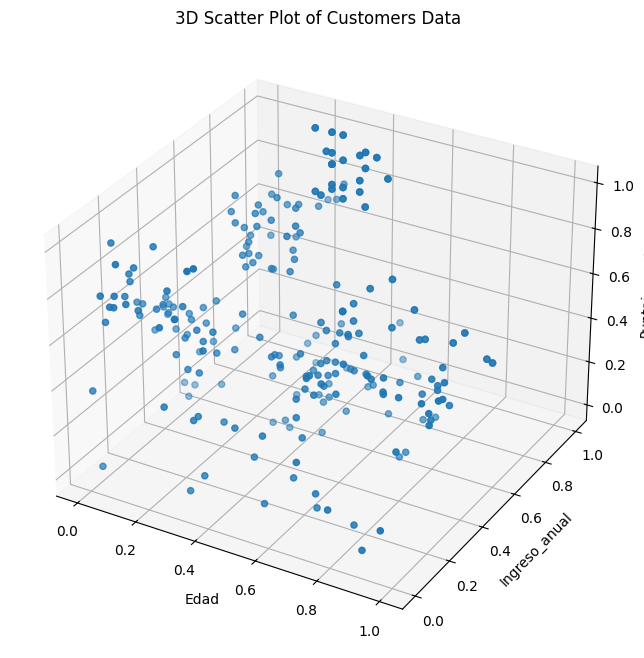

In [ ]:
fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points in 3D
ax.scatter(data_scaled[:, 0], data_scaled[:, 1], data_scaled[:, 2])

ax.set_xlabel('Edad')
ax.set_ylabel('Ingreso_anual')
ax.set_zlabel('Puntaje_gasto')
ax.set_title('3D Scatter Plot of Customers Data')
plt.show()

### 4. Realización del algoritmo
---

#### 1. Obtener la matriz de distancia entre todos los elementos

Obtenemos la matriz de distancias de nuestros datos, la distancia usada es la euclídea.

In [ ]:
D = pairwise_distances(data_scaled, metric='euclidean')
avD = np.average(D)

print(f"Distancia Media: {avD}")

Distancia Media: 0.6649246222893953


#### 2. Constuir el dendograma

Cómo hay distinos métodos para crear el dendograma, podríamos realizar una validación cruzada y ver cual es el que da mejor resultado. En mi caso, he usado la **Correlación de cophenet** que mide cuán fielmente el dendrograma conserva las distancias originales. Aquel resultado más alto es el método que mejor se puede aplicar:

In [ ]:
methods = ['single', 'complete', 'average', 'ward', 'weighted', 'centroid', 'median']
coph_corrs = {}

for method in methods:
    Z = linkage(data_scaled, method=method)
    coph_corr, _ = cophenet(Z, pdist(data_scaled))
    coph_corrs[method] = coph_corr

for method, coph_corr in coph_corrs.items():
    print(f"Correlación de cophenet para {method}: {coph_corr}")

Correlación de cophenet para single: 0.7064329500578774
Correlación de cophenet para complete: 0.741642498956731
Correlación de cophenet para average: 0.7829613822353307
Correlación de cophenet para ward: 0.7418274136288606
Correlación de cophenet para weighted: 0.7291769541858713
Correlación de cophenet para centroid: 0.7432559350462951
Correlación de cophenet para median: 0.7517273592788029


Vemos que la correlación más alta es con el método `average` que da un 78.2%. Una vez tenemos el método escogido, empezamos a ver que umbral de corte es el mejor. Tras unas pruebas, decidí dejarlo en 6 que daba un total de 5 grupos.

<ipython-input-27-9d0b0ed5756f>:3: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = cluster.hierarchy.linkage(D, method='average')


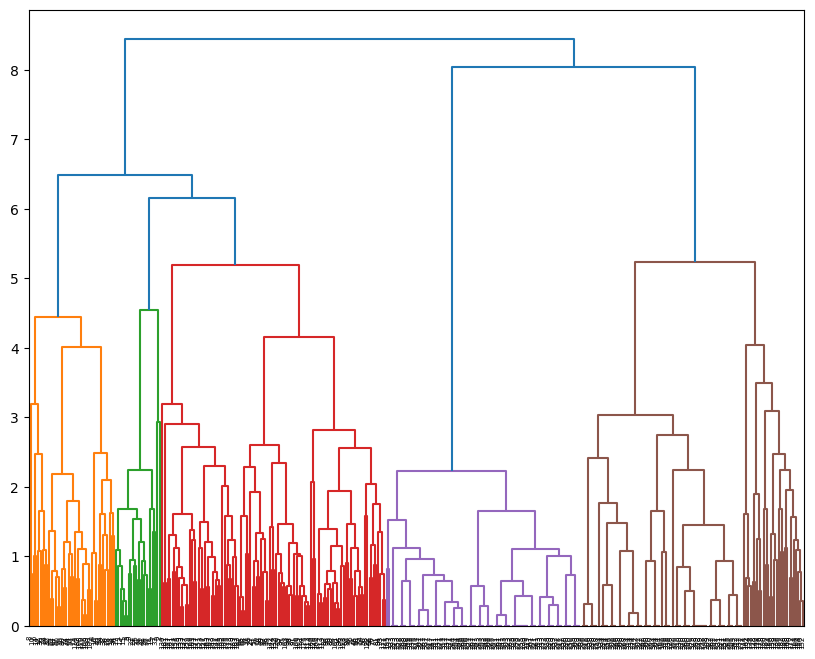

In [ ]:
THRESHOLD = 6

clusters = cluster.hierarchy.linkage(D, method='average')

plt.figure(figsize=(10, 8))
cluster.hierarchy.dendrogram(clusters, color_threshold=THRESHOLD)
plt.show()

#### 3. Obtener el grupo al que pertenece cada observación

Tras elegir el umbral de corte, obtenemos las etiquetas de los grupos para cada dato. Que se ven de la siguiente forma:

In [ ]:
labels = cluster.hierarchy.fcluster(clusters, THRESHOLD , criterion='distance')

print(f"Número de clústeres: {len(set(labels))}")
labels

Número de clústeres: 5


array([2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 2, 1, 2, 1, 3,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 3,
       3, 1, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 1, 1,
       1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 3, 3,
       3, 3, 5, 3, 5, 3, 5, 3, 5, 3, 3, 3, 5, 3, 3, 3, 5, 3, 5, 3, 5, 3,
       5, 3, 5, 3, 5, 3, 3, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3,
       5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 3, 5, 4, 5, 4,
       5, 4, 5, 4, 5, 4, 4, 5, 4, 4, 4, 5, 4, 5, 4, 4, 5, 4, 5, 4, 5, 4,
       5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4,
       5, 4, 4, 5, 4, 4, 4, 5, 4, 5, 4, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4,
       5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 4, 4, 5,
       4, 4, 4, 5, 4, 5, 4, 4, 5, 4, 5, 4, 5, 4, 5,

### 5. Visualización de los resultados
---

Por último, visualizamos los resultados obtenidos.

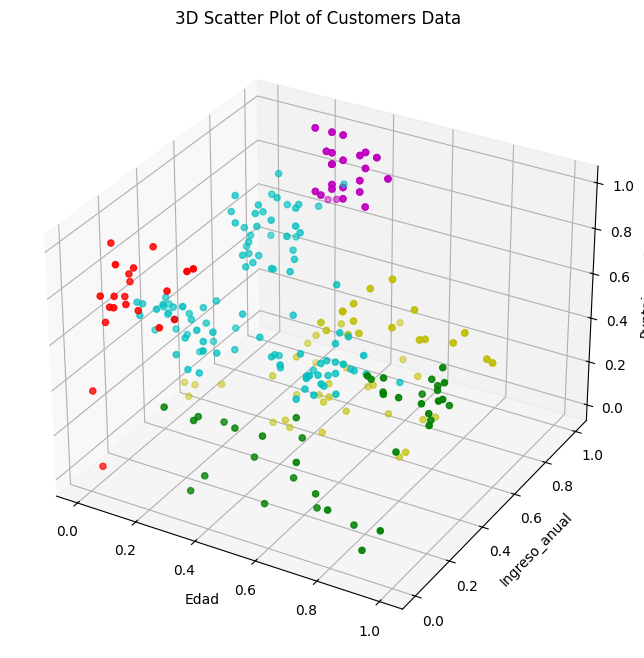

In [ ]:
colores = 'bgrcmyk'

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_scaled[:, 0], data_scaled[:, 1], data_scaled[:, 2], c=[colores[i] for i in labels])

ax.set_xlabel('Edad')
ax.set_ylabel('Ingreso_anual')
ax.set_zlabel('Puntaje_gasto')
ax.set_title('3D Scatter Plot of Customers Data')
plt.show()

Vemos que un grupo se junta a la izquierda de la gráfica, otro se encuentra en la parte superior u los demás están intercalados un poco entre ellos.